In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filepath='/content/drive/MyDrive/data/'
# Load datasets
fraud_data = pd.read_csv(filepath+'Fraud_Data.csv')
creditcard_data = pd.read_csv(filepath+'creditcard.csv')
ip_to_country = pd.read_csv(filepath+'IpAddress_to_Country.csv')

In [9]:
print("Fraud Data Missing Values:\n", fraud_data.isnull().sum())
print("\nCredit Card Data Missing Values:\n", creditcard_data.isnull().sum())

Fraud Data Missing Values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Credit Card Data Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [14]:

creditcard_data.duplicated().sum()

np.int64(1081)

In [13]:
fraud_data.duplicated().sum()

np.int64(0)

In [15]:
creditcard_data = creditcard_data.drop_duplicates()
creditcard_data.duplicated().sum()

np.int64(0)

In [28]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  int64         
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 12.7+ MB


In [19]:
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['ip_address'] = fraud_data['ip_address'].astype("int64")

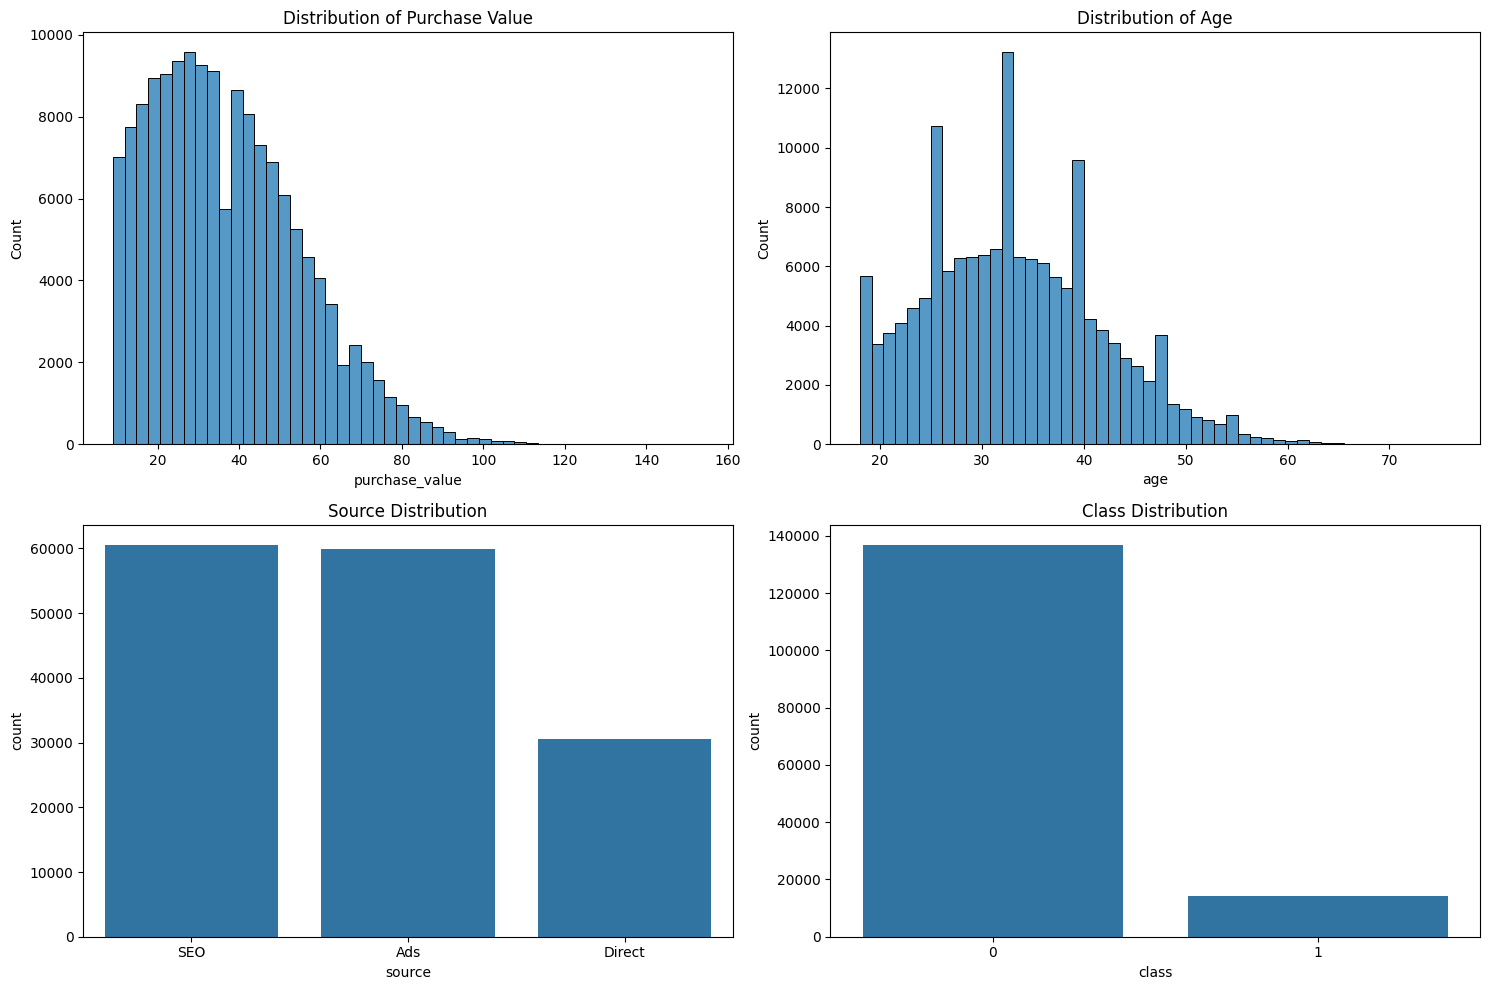

In [33]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(fraud_data['purchase_value'], bins=50)
plt.title('Distribution of Purchase Value')
plt.subplot(2, 2, 2)
sns.histplot(fraud_data['age'], bins=50)
plt.title('Distribution of Age')
plt.subplot(2, 2, 3)
sns.countplot(x='source', data=fraud_data)
plt.title('Source Distribution')
plt.subplot(2, 2, 4)
sns.countplot(x='class', data=fraud_data)
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

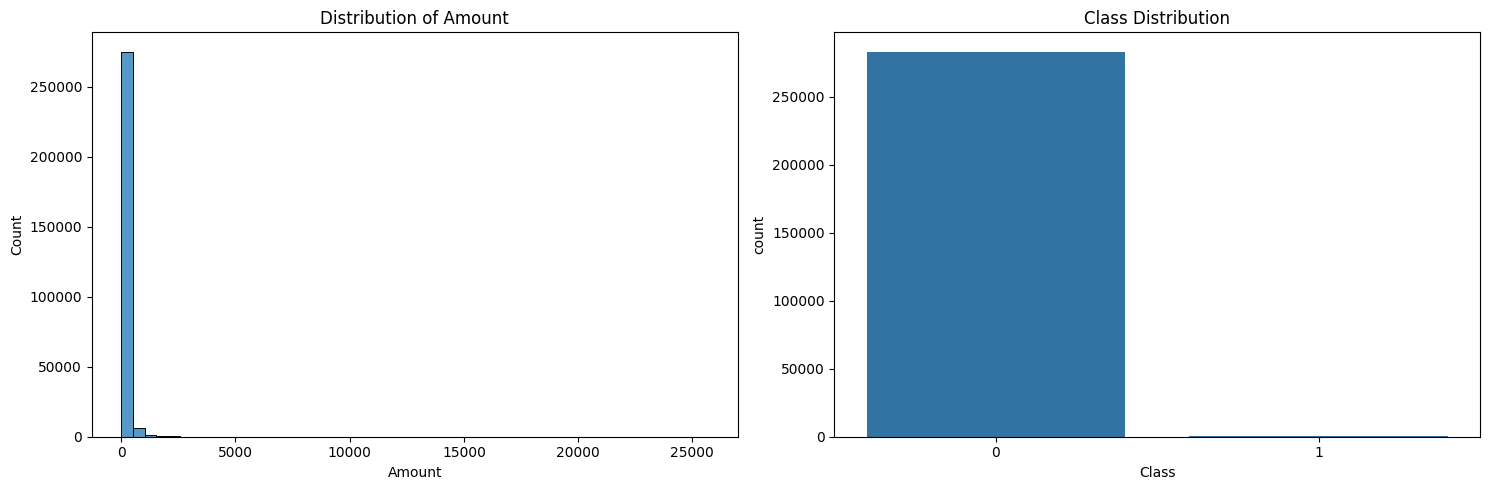

In [35]:
# Univariate Analysis for creditcard.csv
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(creditcard_data['Amount'], bins=50)
plt.title('Distribution of Amount')
plt.subplot(1, 2, 2)
sns.countplot(x='Class', data=creditcard_data)
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

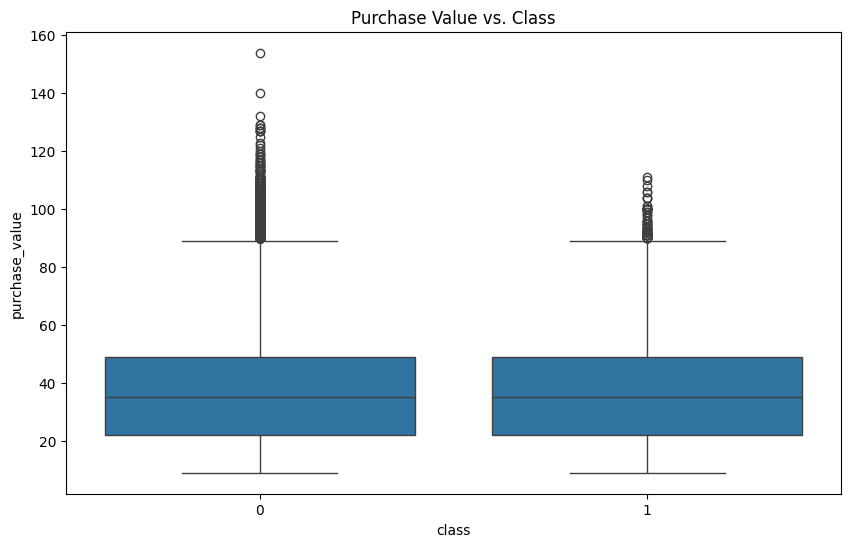

In [40]:
# Bivariate Analysis: Fraud_Data.csv
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value vs. Class')
plt.show()

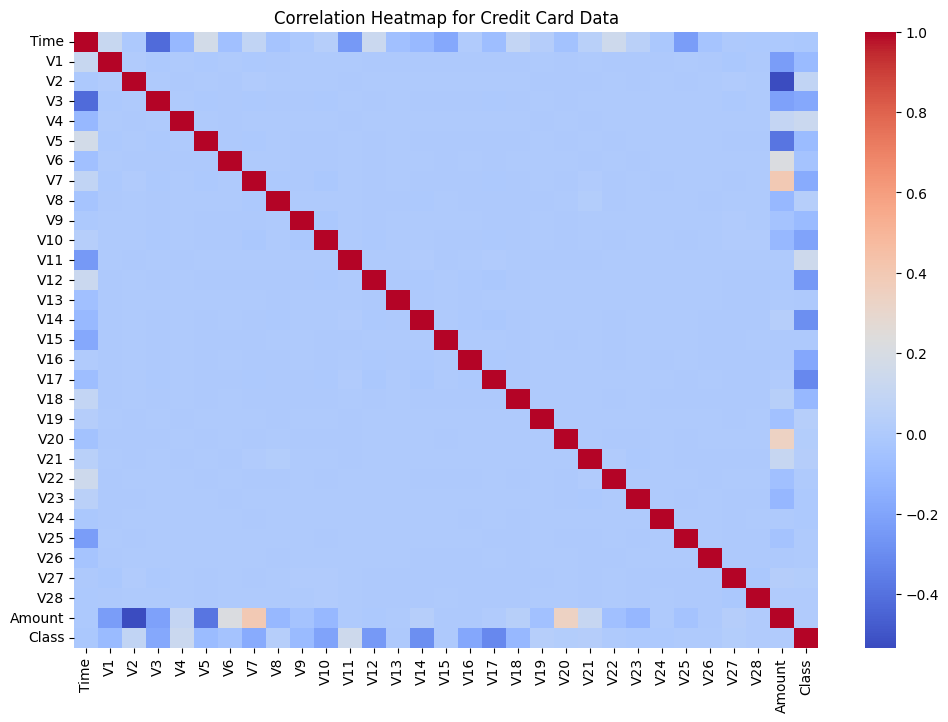

In [41]:
# Correlation heatmap for creditcard.csv
plt.figure(figsize=(12, 8))
sns.heatmap(creditcard_data.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap for Credit Card Data')
plt.show()

In [42]:
# Convert IP address columns to integers
ip_to_country['lower_bound_ip_address'] = ip_to_country['lower_bound_ip_address'].astype("int64")
ip_to_country['upper_bound_ip_address'] = ip_to_country['upper_bound_ip_address'].astype("int64")

# Function to map IP address to country
def map_ip_to_country(ip):
    match = ip_to_country[(ip_to_country['lower_bound_ip_address'] <= ip) &
                          (ip_to_country['upper_bound_ip_address'] >= ip)]
    return match['country'].iloc[0] if not match.empty else 'Unknown'

# Apply mapping to Fraud_Data.csv
fraud_data['country'] = fraud_data['ip_address'].apply(map_ip_to_country)

# Check the result
print(fraud_data[['ip_address', 'country']].head())

   ip_address        country
0   732758368          Japan
1   350311387  United States
2  2621473820  United States
3  3840542443        Unknown
4   415583117  United States


In [53]:
fraud_data = fraud_data[fraud_data['country'] != 'Unknown']



In [56]:
# If fraud_data was filtered, make a full copy first
fraud_data = fraud_data.copy()

# Then assign new columns
fraud_data['user_transaction_count'] = fraud_data.groupby('user_id')['user_id'].transform('count')
fraud_data['device_transaction_count'] = fraud_data.groupby('device_id')['device_id'].transform('count')


In [62]:
fraud_data = fraud_data.sort_values(['device_id', 'purchase_time'])
fraud_data['time_diff'] = fraud_data.groupby('device_id')['purchase_time'].diff().dt.total_seconds() / 3600  # in hours
fraud_data['avg_time_between_transactions'] = fraud_data.groupby('device_id')['time_diff'].transform('mean')

<class 'pandas.core.frame.DataFrame'>
Index: 129146 entries, 34321 to 84217
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   user_id                        129146 non-null  int64         
 1   signup_time                    129146 non-null  datetime64[ns]
 2   purchase_time                  129146 non-null  datetime64[ns]
 3   purchase_value                 129146 non-null  int64         
 4   device_id                      129146 non-null  object        
 5   source                         129146 non-null  object        
 6   browser                        129146 non-null  object        
 7   sex                            129146 non-null  object        
 8   age                            129146 non-null  int64         
 9   ip_address                     129146 non-null  int64         
 10  class                          129146 non-null  int64         
 11  co

In [66]:
# Time-based features
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

In [68]:
fraud_data['avg_time_between_transactions'].fillna(fraud_data['avg_time_between_transactions'].median(), inplace=True)

/tmp/ipython-input-68-1753197150.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_data['avg_time_between_transactions'].fillna(fraud_data['avg_time_between_transactions'].median(), inplace=True)


In [70]:
fraud_data['time_diff'].fillna(fraud_data['time_diff'].median(), inplace=True)

/tmp/ipython-input-70-1300946536.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_data['time_diff'].fillna(fraud_data['time_diff'].median(), inplace=True)


In [71]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129146 entries, 34321 to 84217
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   user_id                        129146 non-null  int64         
 1   signup_time                    129146 non-null  datetime64[ns]
 2   purchase_time                  129146 non-null  datetime64[ns]
 3   purchase_value                 129146 non-null  int64         
 4   device_id                      129146 non-null  object        
 5   source                         129146 non-null  object        
 6   browser                        129146 non-null  object        
 7   sex                            129146 non-null  object        
 8   age                            129146 non-null  int64         
 9   ip_address                     129146 non-null  int64         
 10  class                          129146 non-null  int64         
 11  co

In [72]:
# Analyze class imbalance
print("Fraud Data Class Distribution:\n", fraud_data['class'].value_counts(normalize=True))
print("\nCredit Card Data Class Distribution:\n", creditcard_data['Class'].value_counts(normalize=True))

Fraud Data Class Distribution:
 class
0    0.905007
1    0.094993
Name: proportion, dtype: float64

Credit Card Data Class Distribution:
 Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [73]:
categorical_cols = ['source', 'browser', 'sex', 'country']
fraud_data_encoded = pd.get_dummies(fraud_data, columns=categorical_cols, drop_first=True)

In [74]:
# Separate features and target
X_fraud = fraud_data_encoded.drop(['class', 'signup_time', 'purchase_time', 'user_id', 'device_id', 'ip_address'], axis=1)
y_fraud = fraud_data_encoded['class']
X_credit = creditcard_data.drop('Class', axis=1)
y_credit = creditcard_data['Class']

In [75]:
# Train-test split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42)
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=42)

In [76]:
smote = SMOTE(random_state=42)
X_fraud_train_balanced, y_fraud_train_balanced = smote.fit_resample(X_fraud_train, y_fraud_train)
X_credit_train_balanced, y_credit_train_balanced = smote.fit_resample(X_credit_train, y_credit_train)

In [77]:
# Scale numerical features
scaler = StandardScaler()
X_fraud_train_balanced = scaler.fit_transform(X_fraud_train_balanced)
X_fraud_test = scaler.transform(X_fraud_test)
X_credit_train_balanced = scaler.fit_transform(X_credit_train_balanced)
X_credit_test = scaler.transform(X_credit_test)

In [78]:
# Verify class distribution after SMOTE
print("Fraud Data Balanced Class Distribution:\n", pd.Series(y_fraud_train_balanced).value_counts(normalize=True))
print("\nCredit Card Data Balanced Class Distribution:\n", pd.Series(y_credit_train_balanced).value_counts(normalize=True))

Fraud Data Balanced Class Distribution:
 class
0    0.5
1    0.5
Name: proportion, dtype: float64

Credit Card Data Balanced Class Distribution:
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64
